In [102]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Looking in indexes: https://download.pytorch.org/whl/cu118
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [103]:
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [104]:
tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")
model = AutoModelForSequenceClassification.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

In [105]:
#Collecting reviews of Lush products from Trustpilot and dealing with pagination, cleaning data
reviews = []
def pagination_scrape(webpage, page):
    next_page = webpage + str(page)
    res = requests.get(str(next_page))
    soup = bs(res.text,"html.parser")
    soup_review = soup.find_all("p", {"class":"typography_body-l__KUYFJ typography_appearance-default__AAY17 typography_color-black__5LYEn"})
    for x in range(len(soup_review)):
        reviews.append(soup_review[x].text.strip())
    if page < 118:
        page = page + 1
        pagination_scrape(webpage, page)
pagination_scrape("https://www.trustpilot.com/review/www.lush.co.uk?page=", 1)

In [106]:
#Creating a dataframe
df = pd.DataFrame(reviews, columns=["review"])
df.shape

(2227, 1)

In [107]:
#Using BERT for scoring (1 - lowest, 5 - highest ranking)
def sent_scoring(review):
    tokens = tokenizer.encode(review, return_tensors="pt")
    result = model(tokens)
    return int(torch.argmax(result.logits))+1

In [108]:
df["score"] = df.review.apply(lambda x: sent_scoring(x[:512]))

In [111]:
#example
df[df["score"] == 2][0:25]

,review,score
2,I’m extremely I mean EXTREMELY disappointed in...,2
4,Noticed that the price is increasing very dram...,2
26,"Lush Oxford St, really disappointed with the m...",2
27,Overall overpriced bath bombs aren’t as moistu...,2
64,I’m forced to give LUSH a 2. While there produ...,2
76,I have recently found out that black plastic c...,2
105,Update - Lush have been very busy and offered ...,2
115,order a few gifts for my daughter but spray bo...,2
119,I recently made an order with lush again for m...,2
162,"Nice products (on sale anyway, a bit overprice...",2


In [109]:
scoring = []
for i in range(1,6):
    scoring.append(df[df["score"] == i].count()[0])

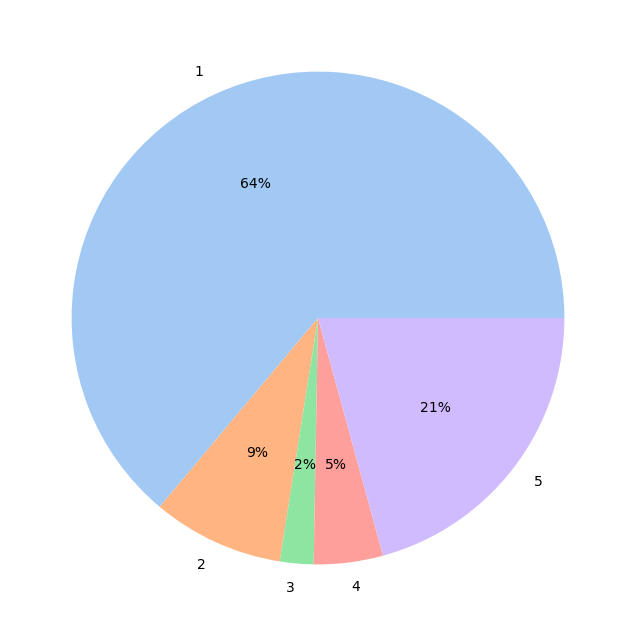

In [110]:
#Results are mostly poor
labels = ['1', '2', '3', '4', '5']
colors = sns.color_palette('pastel')

plt.figure(figsize=[12,8])
plt.pie(scoring, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()